# Температура стали

**Техническое задание.**  
<ins><i>Заказчик:</i></ins>  ООО «Металлургический комбинат «Так закаляем сталь»  
<ins><i>Цели:</i></ins> Оптимизация производственных расходов посредством снижения затрат на электроэнергию на этапе обработки стали  
<ins><i>Задачи:</i></ins> Построение модели, которая предскажет температуру стали  
<ins><i>Исходные данные:</i></ins> набор файлов из различных источников  
<ins><i>Критерии качества:</i></ins> Метрика MAE<=6

<a id='start'></a>
**Содержание**

[1. Загрузка данных](#load)  
[2. Первичный анализ данных](#da)  
[3. Подготовка признаков](#features)  
[4. Обучение моделей](#models)  
[5. Выводы](#conclusion)  
[6. Отчёт](#report)


<a id='da'></a>
## Первичный анализ данных
[В начало](#start)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error


plt.rcParams.update({'font.size':14, 
                     'figure.figsize':(8,6)})
warnings.filterwarnings("ignore")

Загрузка данных

In [ ]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
data_arc.name = 'data_arc'
data_bulk.name = 'data_bulk'
data_bulk_time.name = 'data_bulk_time'
data_gas.name = 'data_gas'
data_temp.name = 'data_temp'
data_wire.name = 'data_wire'
data_wire_time.name = 'data_wire_time'

In [4]:
def sum_info(data):
    '''Вывод общей информации для заданного датафрейма'''
    print(' * ' * 20)
    print(f'File_name: {data.name}')
    print(f'File_shape: {data.shape}')
    display(data.head(3))
    tab = pd.concat([data.dtypes, data.isna().mean()], axis=1)
    tab.columns=['data_type', 'nan_part']
    display(tab.sort_values(by='nan_part', ascending=False))
    print(' * ' * 20)

In [5]:
data_list = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

In [6]:
sum_info(data_list[0])

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
File_name: data_arc
File_shape: (14876, 5)


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805


,data_type,nan_part
key,int64,0.0
Начало нагрева дугой,object,0.0
Конец нагрева дугой,object,0.0
Активная мощность,float64,0.0
Реактивная мощность,float64,0.0


 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


Таблица "Электроды" (data_arc.csv) содержит 14876 строк. Столбцы с со датой/временем определены как строки. Тип данных в столбцах с мощностью правильный, пропущенных данных нет. Из имеющихся сведений интерес может представлять общее время нагрева и потребляемая нагревателем мощность.  
Видно, что этапов нагрева может быть несколько, поэтому оценим распределение количества этапов нагрева. 

In [7]:
data_arc.groupby(by='key')['key'].count().describe() 

count    3214.000000
mean        4.628500
std         1.608647
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: key, dtype: float64

Минимальное количество циклов нагрева - 1, максимальное - 16, в среднем 4. Всего партий 3214.  
Посмотрим как распределена мощность и как связаны между собой активная и реактивная мощности. 

In [8]:
data_arc[['Активная мощность', 'Реактивная мощность']].describe()

,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000
mean,0.670441,0.452592
std,0.408159,5.878702
min,0.030002,-715.504924
25%,0.395297,0.290991
50%,0.555517,0.415962
75%,0.857034,0.637371
max,3.731596,2.676388


В реактивной мощности есть аномалия - отрицательное значение.

In [9]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Видимо какой-то глюк при измерениях. Посмотрим как связаны эти две величины.

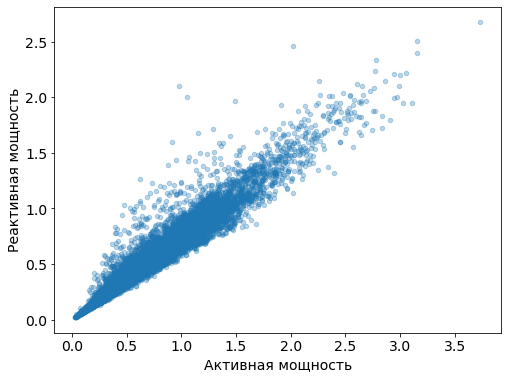

In [10]:
data_arc[data_arc['Реактивная мощность'] >= 0].plot(x='Активная мощность', 
                                                    y='Реактивная мощность', 
                                                    kind='scatter', alpha=0.3)
plt.show()

Видно весьма ощутимую взаимосвязь. Впрочем, это и есть две крайности одной сущности и, возможно, в будущем их стоит объединить в один признак "полная мощность" через соотношение:  

$$ 
S = \sqrt{P^2 + Q^2}
$$ 
где: S - полная мощность, Р - активная, Q - реактивная

  
Смотрим следующую таблицу.

In [11]:
sum_info(data_list[1])

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
File_name: data_bulk
File_shape: (3129, 16)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


,data_type,nan_part
Bulk 8,float64,0.999680
Bulk 13,float64,0.994247
Bulk 9,float64,0.993928
Bulk 2,float64,0.992969
Bulk 7,float64,0.992010
Bulk 5,float64,0.975391
Bulk 10,float64,0.943752
Bulk 11,float64,0.943432
Bulk 1,float64,0.919463
Bulk 6,float64,0.815916


 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


Таблица "Сыпучие материалы" ('data_bulk') содержит сведения об объёме добавленных материалов в расплав. Все данные числовые, однако содержится большое количество пропусков, которые говорят нам о том, что-то в расплав не добавлялось. А если не добавлялось, значит пропуски можно заменить на нули. Но пока открыт вопрос о том, насколько этот признак является значимым. 

In [12]:
sum_info(data_list[2])

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
File_name: data_bulk_time
File_shape: (3129, 16)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40


,data_type,nan_part
Bulk 8,object,0.999680
Bulk 13,object,0.994247
Bulk 9,object,0.993928
Bulk 2,object,0.992969
Bulk 7,object,0.992010
Bulk 5,object,0.975391
Bulk 10,object,0.943752
Bulk 11,object,0.943432
Bulk 1,object,0.919463
Bulk 6,object,0.815916


 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


Таблица "Сыпучие материалы (время" ('data_bulk_time') содержит сведения о времени добавления материалов в расплав. Пропуски симметричны предыдущей таблице.

In [13]:
sum_info(data_list[3])

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
File_name: data_gas
File_shape: (3239, 2)


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


,data_type,nan_part
key,int64,0.0
Газ 1,float64,0.0


 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


В таблице "data_gas" дано что-то про продувку расплава инертным газом.

In [14]:
data_gas.agg(['count','min','max', 'mean'])

,key,Газ 1
count,3239.000000,3239.000000
min,1.000000,0.008399
max,3241.000000,77.995040
mean,1621.861377,11.002062


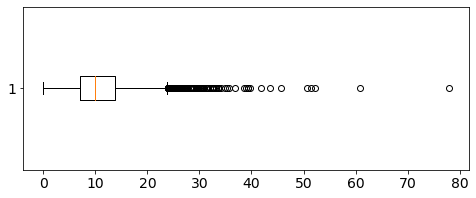

In [15]:
plt.figure(figsize=(8, 3))
plt.boxplot(data_gas['Газ 1'], vert=False)
plt.show()

Имеются выбросы, но не очень сильные. С этим можно жить.  
Смотрим следующую таблицу.

In [16]:
sum_info(data_list[4])

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
File_name: data_temp
File_shape: (15907, 3)


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0


,data_type,nan_part
Температура,float64,0.182373
key,int64,0.000000
Время замера,object,0.000000


 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


А здесь у нас сведения о температуре. Где-то здесь должен быть наш целевой признак. Температура здесь дана одна, но в разные периоды времени. Причём примерно в 18% случаев она пропущена. Нехорошо. И снова дата не дата...

In [17]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], 
                                           format='%Y-%m-%d %H:%M:%S')

In [18]:
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


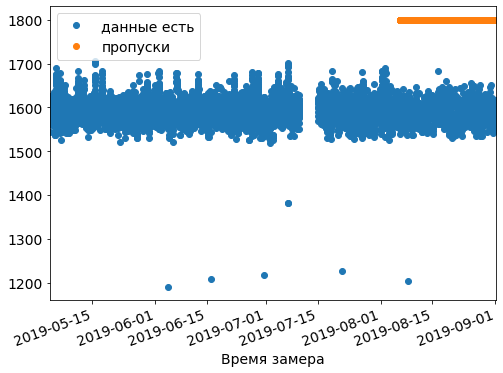

In [19]:
ax = data_temp.plot(x='Время замера', 
                    y='Температура', 
                    label='данные есть',
                    style='o')
(data_temp[data_temp['Температура'].isna()]
                                    .fillna(1800)
                                    .plot(x='Время замера', 
                                          y='Температура',
                                          style='o', 
                                          ax=ax, label='пропуски'))
plt.legend()
plt.xticks(rotation=20)
plt.show()

Есть несколько выбросов температуры значительно ниже среднего значения. Это может быть как ошибка в измерениях, так и отклонения в техническом процессе. Но температура плавления чугуна 1150-1200 градусов, так что значение расплава 1200 хоть и подозрительно, но возможно но на аномалию не тянет.  
Есть период, где измерения температуры отсутствуют полностью, но это не критично. А вот все пропуски сосредоточены на последнем временном промежутке. 

In [20]:
data_temp[data_temp['Температура'].isna()].head()

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN


In [21]:
data_temp[data_temp['key'] >= 2500].head(10)

,key,Время замера,Температура
12267,2500,2019-08-06 03:11:31,1539.0
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12271,2501,2019-08-06 03:44:42,1587.0
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN
12276,2502,2019-08-06 04:45:26,1583.0


In [22]:
(data_temp[data_temp['key'] >= 2500]
    .fillna(-1).groupby(by='key')['Температура']
    .agg(['first', 'last'])
    .agg(['min', 'max']))

,first,last
min,1204.0,-1.0
max,1684.0,-1.0


Получается, что с 2500 партии в данных отсутствуют все измерения температуры, кроме первого. Если целевым признаком является последнее измерение температуры, то все данные после 2500 партии для обучения модели нам не подходят.

In [23]:
sum_info(data_list[5])

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
File_name: data_wire
File_shape: (3081, 10)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,data_type,nan_part
Wire 5,float64,0.999675
Wire 7,float64,0.996430
Wire 4,float64,0.995456
Wire 8,float64,0.993833
Wire 9,float64,0.990587
Wire 3,float64,0.979552
Wire 6,float64,0.976306
Wire 2,float64,0.649789
Wire 1,float64,0.008439
key,int64,0.000000


 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


А здесь краткая сводка по таблице "wire" - проволочные материалы. Она выполняет ту же функцию, что и bulk и судя по большому количеству пропусков, проволоку добавляют редко, кроме Wire_1 и Wire_2. 

In [24]:
sum_info(data_list[6])

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
File_name: data_wire_time
File_shape: (3081, 10)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,data_type,nan_part
Wire 5,object,0.999675
Wire 7,object,0.996430
Wire 4,object,0.995456
Wire 8,object,0.993833
Wire 9,object,0.990587
Wire 3,object,0.979552
Wire 6,object,0.976306
Wire 2,object,0.649789
Wire 1,object,0.008439
key,int64,0.000000


 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


Ну то же самое - есть записи только там, где что-то добавили, иначе - пропуски.

<a id='features'></a>
## Подготовка признаков
[В начало](#start)

### Работа электродов

На текущем этапе необходимо сформировать общий датафрейм, состоящий из признаков, пригодных для обучения модели. Для этого нужно из каждой из имеющихся таблиц вытащить подходящие данные и сформировать из них признаки.  

Начнём по порядку. В таблице data_arc у нас есть два вида мощности и по несколько итераций нагрева. Так как в качестве целевого признака нас интересует последняя температура в партии, то всё, что происходит в рамках этой партии с потреблением энергии логичнее всего просуммировать. Но сначала вычислим время работы нагревателя и полную мощность.

In [25]:
# Переименование столбцов на латиницу
data_arc = data_arc.rename(columns={'Начало нагрева дугой':'time_start',
                         'Конец нагрева дугой':'time_finish',
                         'Активная мощность':'act_power',
                         'Реактивная мощность':'react_power'
                         })

# Удаление аномалии
data_arc = data_arc.query('react_power > 0')

# Преобразование столбцов с датой в дату
data_arc['time_start'] = pd.to_datetime(data_arc['time_start'], format='%Y-%m-%d %H:%M:%S')
data_arc['time_finish'] = pd.to_datetime(data_arc['time_finish'], format='%Y-%m-%d %H:%M:%S')

# Вычисление времени работы нагревателя
data_arc['action_time'] = (data_arc['time_finish'] - data_arc['time_start']).dt.seconds

# Вычисление полной мощности
data_arc['total_power'] = (data_arc['act_power']**2 + data_arc['react_power']**2) ** 0.5

# Проверка 
data_arc.head(3)

,key,time_start,time_finish,act_power,react_power,action_time,total_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038


А теперь выполним группировку с суммированием и получим готовую часть признаков. 

In [26]:
data_arc_features = (
    data_arc.groupby('key')[['action_time', 'act_power', 
                             'react_power', 'total_power', 'key']]
    .agg({'action_time':'sum', 'act_power':'sum', 
          'react_power':'sum', 'total_power':'sum', 'key':'count'}))
data_arc_features.rename(columns={'key':'heat_steps'}, inplace=True)
data_arc_features.head()

,action_time,act_power,react_power,total_power,heat_steps
key,,,,,
1,1098,4.878147,3.183241,5.826395,5
2,811,3.052598,1.998112,3.649216,4
3,655,2.525882,1.599076,2.989534,5
4,741,3.209250,2.060298,3.814962,4
5,869,3.347173,2.252643,4.035758,4


Возможно эти признаки сильно коррелируют между собой, но с этим разберёмся позже. Пока посмотрим что получилось.

In [27]:
data_arc_features.describe()

,action_time,act_power,react_power,total_power,heat_steps
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,794.545115,3.102984,2.317442,3.881975,4.628189
std,332.491076,1.397556,1.054316,1.740260,1.608866
min,57.000000,0.186226,0.158247,0.257637,1.000000
25%,571.000000,2.126339,1.599018,2.674763,4.000000
50%,770.000000,2.990537,2.229869,3.749955,4.000000
75%,983.000000,3.901147,2.899141,4.858563,6.000000
max,4189.000000,17.496497,12.587990,21.564771,16.000000


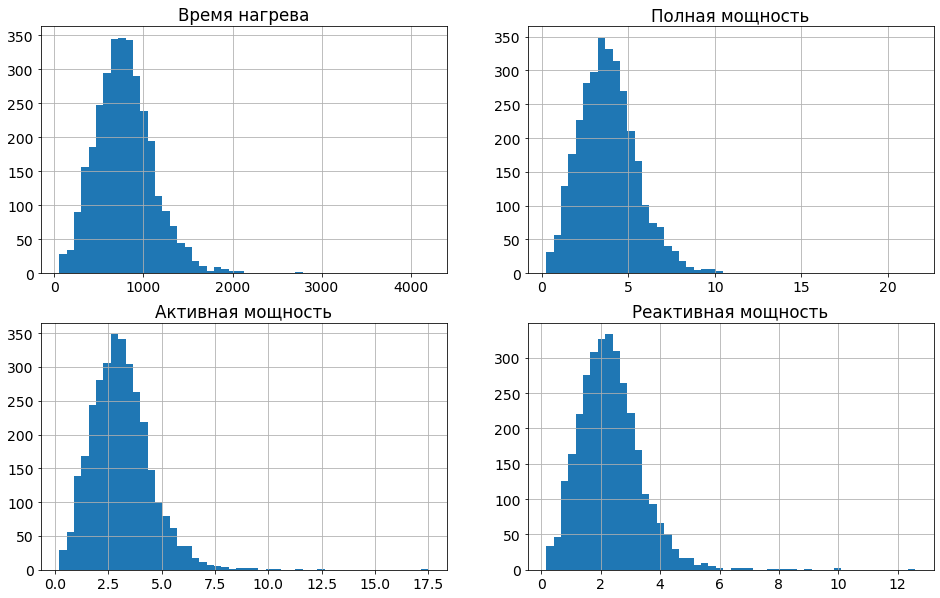

In [28]:
plt.figure(figsize=(16,10))
plt.subplot(2, 2, 1)
data_arc_features['action_time'].hist(bins=50)
plt.title('Время нагрева')

plt.subplot(2, 2, 2)
data_arc_features['total_power'].hist(bins=50)
plt.title('Полная мощность')

plt.subplot(2, 2, 3)
data_arc_features['act_power'].hist(bins=50)
plt.title('Активная мощность')

plt.subplot(2, 2, 4)
data_arc_features['react_power'].hist(bins=50)
plt.title('Реактивная мощность')
plt.show()

Нормальное распределение, за исключением небольшого хвоста. Но это вполне рабочий момент, оставим как есть. 

### Сыпучие материалы

Сыпучие материалы представлены двумя таблицами - с объемом и временем. В сущности, конкретное время добавления присадок в процессе подготовки партии для нас особой роли не играет, поскольку время между добавками уже учтено в работе нагревателей. Поэтому будем работать только с таблицей, содержащей объёмные величины.  

Первым делом установим в качестве индекса номер партии.

In [29]:
data_bulk = data_bulk.set_index('key')

Пока попробуем в качестве признаков использовать суммарный объём всех присадок и общее их количество.

In [30]:
#data_bulk.drop(['sum_bulk', 'count_bulk'], axis=1, inplace=True)
data_bulk['count_bulk'] = data_bulk.count(axis=1)
data_bulk['sum_bulk'] = data_bulk[data_bulk.drop('count_bulk', axis=1).columns].sum(axis=1)
data_bulk.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,count_bulk,sum_bulk
key,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,4,553.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,4,582.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,4,544.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,4,595.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,4,584.0


In [31]:
data_bulk_features = data_bulk[['sum_bulk', 'count_bulk']]
data_bulk_features.head()

,sum_bulk,count_bulk
key,,
1,553.0,4
2,582.0,4
3,544.0,4
4,595.0,4
5,584.0,4


### Проволочные материалы

С проволокой сделаем то же самое, что и с сыпучими материалами. 

In [32]:
data_wire = data_wire.set_index('key')
data_wire['count_wire'] = data_wire.count(axis=1)
data_wire
data_wire['sum_wire'] = data_wire[data_wire.drop('count_wire', axis=1).columns].sum(axis=1)
data_wire.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,count_wire,sum_wire
key,,,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,60.059998
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,96.052315
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,91.160157
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,89.063515
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,98.352796


In [33]:
data_wire_features = data_wire[['sum_wire', 'count_wire']]
data_wire_features.head()

,sum_wire,count_wire
key,,
1,60.059998,1
2,96.052315,1
3,91.160157,1
4,89.063515,1
5,98.352796,2


### Газ

Табличка с газом нареканий не вызывала. В ней мы просто сделаем номер партии индексом, чтобы потом было проще все таблицы объединить.

In [34]:
data_gas_features = data_gas.set_index('key').rename(columns={'Газ 1':'gas'})
data_gas_features.head()

,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


### Температура

Как выяснили ранее, из всех измерений температуры в партии нам нужны только первая и последняя, причём начиная с 2500 партии наличествует только первая. Выделим нужные данные.

In [35]:
data_temp_features = (data_temp.groupby('key')['Температура']
                      .agg(['first', 'last']).loc[:2499])
data_temp_features = data_temp_features.rename(columns={'first':'init_temp', 'last':'last_temp'})
data_temp_features.head()

,init_temp,last_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


Теперь можем объединить все получившиеся таблицы в один общий датафрейм.

### Объединённые данные. 

In [36]:
df = (
    data_temp_features
    .join(data_bulk_features)
    .join(data_arc_features)
    .join(data_wire_features)
    .join(data_gas_features)
    )
df

,init_temp,last_temp,sum_bulk,count_bulk,action_time,act_power,react_power,total_power,heat_steps,sum_wire,count_wire,gas
key,,,,,,,,,,,,
1,1571.0,1613.0,553.0,4.0,1098.0,4.878147,3.183241,5.826395,5.0,60.059998,1.0,29.749986
2,1581.0,1602.0,582.0,4.0,811.0,3.052598,1.998112,3.649216,4.0,96.052315,1.0,12.555561
3,1596.0,1599.0,544.0,4.0,655.0,2.525882,1.599076,2.989534,5.0,91.160157,1.0,28.554793
4,1601.0,1625.0,595.0,4.0,741.0,3.209250,2.060298,3.814962,4.0,89.063515,1.0,18.841219
5,1576.0,1602.0,584.0,4.0,869.0,3.347173,2.252643,4.035758,4.0,98.352796,2.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,719.0,5.0,723.0,3.210690,2.360777,3.986869,4.0,89.150879,1.0,7.125735
2496,1554.0,1591.0,796.0,5.0,940.0,4.203064,2.810185,5.057033,6.0,114.179527,1.0,9.412616
2497,1571.0,1589.0,665.0,4.0,569.0,2.212379,1.851269,2.885017,3.0,103.134723,2.0,6.271699


Оценим количество пропусков в общей таблице.

In [37]:
df.isnull().sum()

init_temp        0
last_temp        0
sum_bulk        69
count_bulk      69
action_time      2
act_power        2
react_power      2
total_power      2
heat_steps       2
sum_wire       104
count_wire     104
gas              2
dtype: int64

Что касается добавления различных материалов и газа, то пропуски означают, что ничего в расплав не добавляли, то есть замена - ноль. Касаемо нагрева скорее всего так же. Но проверим:

In [38]:
df[(df['action_time'].isnull()) | (df['total_power'].isnull()) | (df['heat_steps'].isnull())]

,init_temp,last_temp,sum_bulk,count_bulk,action_time,act_power,react_power,total_power,heat_steps,sum_wire,count_wire,gas
key,,,,,,,,,,,,
195,1583.0,1583.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.374436
279,1603.0,1603.0,89.0,1.0,NaN,NaN,NaN,NaN,NaN,99.066236,1.0,7.232359


Да, температура на старте и на финише одинаковая, стало быть нагрева не было.. Хотя странно, а само чтоль нисколько не остыло? Будем считать, что нет. У нас же нет предпосылок не доверять исходным данным, ведь правда?))

In [39]:
df = df.fillna(0)

Оценим мультиколлинеарность между получившимися признаками. 

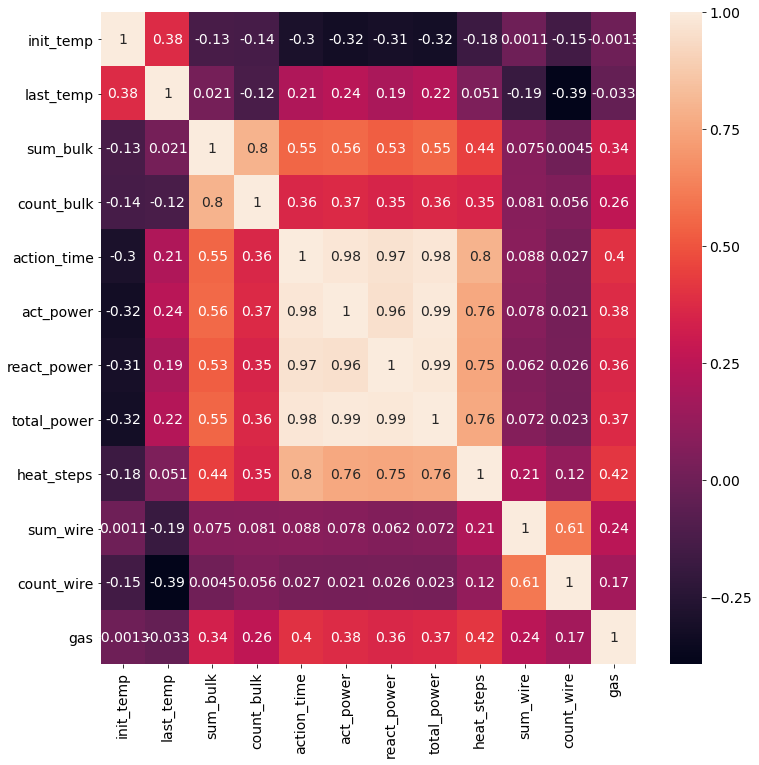

In [40]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True)
plt.show()

Из тепловой карты мы видим, что между собой сильно коррелируют выделенные нами признаки из общих групп, например total_power и action_time, что в общем-то логично - чем дольше греем, тем больше энергии потратим, а все виды мощности между собой связаны. То же самое можно сказать про добавление материалов. Поэтому исключим из обучения ряд признаков. 

(прим. автора - *После нескольких итераций моделирования пришёл к следующему:*)
Из признаков исключим время нагрева, так как оно сильно коррелирует с затраченной мощностью. Полная мощность также оказалась невостребована - с ней хуже. Реактивная мощность тоже мешается, что и логично - это та мощность, которая возвращается в сеть, то есть в процессе нагрева она не участвует. 

In [41]:
cols_to_drop = ['action_time', 'total_power', 'react_power',]

<a id='models'></a>
## Обучение моделей
[В начало](#start)

### Разделение выборок

Выделим целевой признак и разделим выборки на обучающую и тестовую

In [42]:
target_name = 'last_temp'

target = df[target_name]
features = df.drop(target_name, axis=1).drop(cols_to_drop, axis=1)

In [43]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

Проверка:

In [44]:
len(features_train) + len(features_test) == len(features)

True

### Линейная регрессия

Начнём с простого - линейной регрессии.

In [45]:
model = LinearRegression()
model.fit(features_train, target_train)
result = model.predict(features_test)
linreg_score = mean_absolute_error(target_test, result)
print('MAE=', linreg_score)

MAE= 7.506243492879418


Попробуем ещё

### Случайный лес

Попробуем случайный лес с гиперпараметрами по умолчанию (*потому что с подбором результат не сильно лучше* - прим. автора)

In [46]:
model = RandomForestRegressor(random_state=42)
model.fit(features_train, target_train)
result = model.predict(features_test)
forest_score = mean_absolute_error(target_test, result)
print('MAE=', forest_score)

MAE= 6.321822580645162


Уже получше. Попробуем ещё что-нибудь.

### XGBoost

Тяжёлая артиллерия.

In [47]:
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.015,
    reg_alpha=15,
    objective='reg:squarederror',
    random_state=12345
)
model.fit(features_train, target_train)

result = model.predict(features_test)
xgb_score = mean_absolute_error(target_test, result)
print('MAE=', xgb_score)

MAE= 5.926727885584677


Мы достигли требуемого результата. МАЕ на тесте уже меньше 6. 

### CatBoost 

Ну и последнее

In [48]:
model = CatBoostRegressor(
    loss_function='MAE', 
    random_state=12345, 
    iterations=1000, 
    learning_rate=0.008, 
    l2_leaf_reg=50,
    )
model.fit(features_train, target_train, verbose=200)

result = model.predict(features_test)
cb_score = mean_absolute_error(target_test, result)
print('\nTest MAE =', cb_score)

0:	learn: 9.9184610	total: 49.6ms	remaining: 49.5s
200:	learn: 7.1426849	total: 2.54s	remaining: 10.1s
400:	learn: 6.2768345	total: 5.03s	remaining: 7.51s
600:	learn: 5.8672357	total: 7.64s	remaining: 5.07s
800:	learn: 5.5954380	total: 10.3s	remaining: 2.55s
999:	learn: 5.3681466	total: 12.9s	remaining: 0us

Test MAE = 5.864735110932099


Ещё лучше. Так и оставим. На всякий случай сравним результат с фиктивным предсказанием - по среднему.  
Затем посмотрим что получилось.

In [49]:
dummy_pred = pd.Series(target_train.mean(), index=target_test.index)
dummy_result = mean_absolute_error(target_test, dummy_pred)
print('Dummy MAE =', dummy_result)

Dummy MAE = 10.018140601386204


In [50]:
(
    pd.Series(
    data=[linreg_score, forest_score, xgb_score, cb_score, dummy_result],
    index=['LinearRegression', 'RandomForest', 'XGB', 'CatBoost', 'Dummy_mean'],
    name='score'
    )
    .sort_values()
    .to_frame()
)

,score
CatBoost,5.864735
XGB,5.926728
RandomForest,6.321823
LinearRegression,7.506243
Dummy_mean,10.018141


Посмотрим, какие признаки оказались определяющими.

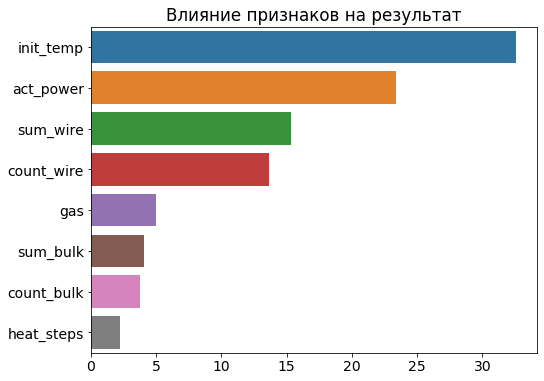

In [51]:
importances = (
    pd.Series(model.feature_importances_, index=features.columns)
    .sort_values(ascending=False)
    )

sns.barplot(y=importances.index, x=importances)
plt.title('Влияние признаков на результат')
plt.show()

Начальная температура сильнее всего влияет на конечную. Затраченная мощность тоже. А вот количество циклов нагрева и сыпучие добавки на результат предсказания модели влияют не сильно.  

<a id='conclusion'></a>
## Выводы
[В начало](#start)

Решена задача построения модели прогнозирования температуры стали на основании исторических данных технического процесса. Выполнены следующие этапы работы:
* Проведен первичный анализ полученных от Заказчика данных, определён план дальнейшей работы. Выявлено отсутствие необходимых данных по температуре начиная с 2500 партии. 
* Определена целевая переменная - последняя температура в партии. Выделены необходимые для построения моделей признаки и проведена их подготовка. Данные техпроцесса сгруппированы по номеру партии. Введены такие признаки как суммарный объём добавленных материалов, количество этапов нагрева, время нагрева, полная мощность (последние два в процессе разработки исключены). 
* Обучено 4 модели. Лучший результат на тестовой выборке МАЕ=5.9. Определена важность признаков. 

